In [1364]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import wordnet
import datetime
import time
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('brown')

In [1261]:
# set settings
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
2
# Width of the display in characters. If set to None and pandas will correctly auto-detect the width.
pd.set_option('display.max_colwidth', 150)

In [1422]:
rc = pd.read_csv("simplyrecipes.csv")

In [1423]:
# missing values
# if dish is missing, discard data
rc.dropna(subset=['dish'], inplace=True)
# drop column with no ingredients
rc.dropna(subset=['ingredients'], inplace=True)
# if cook time missing, discard data
#rc = rc[rc[['time_cook', 'time_prep']].notna().any(axis = 1)]
rc.dropna(subset=['time_cook'], inplace=True)
rc.dropna(subset=['time_prep'], inplace=True)
# drop num_comment column, all NaN
rc = rc.drop(columns = ['num_comment', 'time_other_type','time_other', 'time_other_full'])
# drop no tag rows
rc.dropna(subset = ['tags'], inplace = True)

In [1424]:
# split cell content string to list
lst1 = ['time_cook', 'time_prep', 'tags']
rc[lst1] = rc[lst1].apply(lambda x: x.str.split(','))

In [1425]:
# change rating star to numbers
rc.rating_star.unique() # only 5 starts
rc['rating_star'] = rc.rating_star.str.replace('yyyyy', '5')

In [1426]:
# clean ingredients with regex
# lower case all letters
rc['inglst'] = rc.ingredients.str.lower()
# get rid of number & punctuation 
rc['inglst'] = rc.inglst.apply(lambda x: re.sub('\W', " ", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub('\d', " ", x))

In [1427]:
# remove common seasoning
lst4 = ["olive oil", "sea salt", "black pepper"]
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("olive oil", "", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("sea salt", "", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("black pepper", "", x))
rc['inglst'] = rc.inglst.apply(lambda x: re.sub("soy sauce", "", x))

In [1428]:
# tokenize ingredients
def safe_word_tokenize(x):
    try:
        return word_tokenize(x)
    except:
        return 'empty'
#rc['inglst'] = rc.ingredients.apply(safe_word_tokenize)
rc['inglst'] = rc.inglst.apply(word_tokenize)

In [1437]:
# customize stop words list
lst2 = ['pinch','approx','inch','inches','cups','cup','ml','tablespoons','tablespoon','tbsp', 'teaspoon','teaspoons','kg','g','grams','gram','lbs','lb','pound','pounds','ounce','ounces','oz']
lst3 = ['virgin','slices','ground','piece','pieces','medium','cut','half', 'strips','kosher','stock','powder','taste','cube','handful','wedge','wedges']
lst4 = ['salt','oil','water','sugar','cream','sauce','mustard','cumin','oregano','clove','cloves','parsely','cilantro','basil','scallion','thyme','garlic','butter','canola','ginger']
stopIng = stopwords.words('english')
stopIng.extend(lst2)
stopIng.extend(lst3)
stopIng.extend(lst4)
#print(stopIng)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [1430]:
# exlude stop words from inglst
rc['inglst'] = rc.inglst.apply(lambda x: [el for el in x if el not in stopIng])

In [1431]:
# only keep nouns in inglst
rc['inglst'] = rc.inglst.apply(nltk.pos_tag)
def only_noun(lst):
    nouns = [word for (word, pos) in lst if pos[:2]=="NN"]
    return nouns
rc['inglst'] = rc.inglst.apply(only_noun)

In [1432]:
# parse time
def unify_time(lst):
    time = dict()
    for item in lst:
        item = item.lstrip()
        if 'hour' in item:
            hour = int(re.sub('\D', '', item))
            time.update({'hour':hour})

        if 'minute' in item:
            minute = int(re.sub('\D', '', item))
            time.update({'minute':minute})

    duration = time.get('hour', 0)*60 + time.get('minute', 0)
    return duration
rc['time_cook'] = rc.time_cook.apply(unify_time)
rc['time_prep'] = rc.time_prep.apply(unify_time)

In [1433]:
# parse tag
rc['tags'] = rc.tags.apply(lambda x: [el.lower() for el in x ])

In [1434]:
inglst_values = rc.inglst.values
inglst_values.tolist()
alling = [item for sublist in inglst_values for item in sublist]
#alling

In [1435]:
# word cloud of inglst
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400)
#wc.generate(' '.join(rc['inglst'][0]))
wc.generate(' '.join(alling))

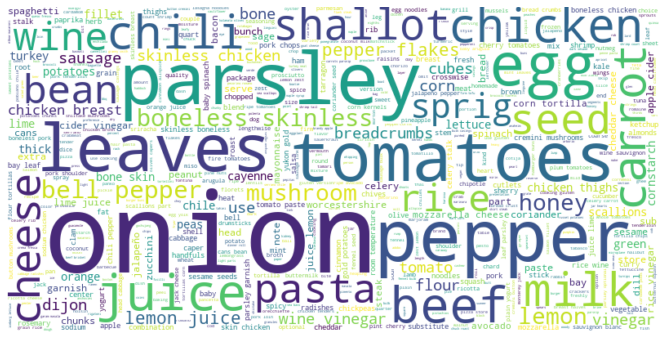

In [1436]:
# show
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
#plt.savefig('ingredient')

In [1361]:
# take the last 2 words of ing
#rc['ing'] = rc.ingredients.apply(lambda x: re.sub('\(.*\)', '', x))
#rc.ing
#rc.ing.apply(lambda x: [el for el in x.split() if el not in stopIng])

0                                                                                        4 cups cauliflower florets ,Fresh chopped parsley,Fried sage leaves
2                                                                                         1 tablespoon extra virgin olive oil,1 bunch  grated cheddar cheese
3      Butter  summer squash, cut on the diagonal into 1/4-inch-thick slices,4 small tomatoes, halved,Olive oil, for brushing the vegetables,Salt and pepper
5      2 cups cauliflower, chopped into bite-size pieces,2 teaspoons neutral oil,Pinch of sea salt,2 tablespoons ,2 tablespoons ,4 8-inch corn tortillas,...
6      2 tablespoons extra virgin olive oil,1 1/2 pound skinless chicken breast, cut into 1 inch cubes,Salt,1 yellow onion, roughly chopped,2 heaping tab...
                                                                               ...                                                                          
930                        2-4 boneless, skinless chicken 

In [1018]:
# food = wordnet.synset('food.n.02')
# for i in food.closure(lambda s:s.hyponyms()):
#     print(i)

In [551]:
# test why wordtokenize did not work on column ingredients
# def safe_word_tokenize( x ):
#     try:
#         return word_tokenize( x )
#     except Exception as e:
#         print( f"Error with {x}. Exception given: {e}" )
#         print( "-"*25 + "\n" )
# rc.ingredients.apply(safe_word_tokenize)

In [352]:
# extract time
#rc['time_cook'].apply(lambda x: x.split(','))
# rc['time_cook'] = rc['time_cook'].str.split(',')
# rc['time_prep'] = rc['time_prep'].str.split(',')
# rc['ingredients'] = rc.ingredients.str.split(',')
# rc['tags'] = rc.tags.str.split(',')
#rc.rating_star.str.replace('yyyyy', 5)
#rc.rating_star.str.replace('yyyyy', '5')

In [1259]:
# old wrong codes
#rc['inglst'].apply(lambda x: x if x not in stopIng else '')
#rc.inglist.apply(lambda x: re.sub(lambda y: y, lst4), "", x)

In [ ]:
# need work code
# def remove_season(lst,x):
#     for item in lst:
#         re.sub(item, "", x)
# rc.inglst.apply(remove_season, lst4)
# blob = TextBlob(" ".join(rc.inglst.iloc[1]))
# print(blob.noun_phrases)

In [ ]:
#df = pd.read_csv('https://s3.amazonaws.com/nycdsabt01/movie_metadata.csv')

In [ ]:
# IDEAS
#rc.ingredients.sample(5)
# only take the last two words of each , separated words in ingredients
#rc.sample(5)

In [ ]:
# reference code
#rc.inglst.apply( lambda x: [el for el in x if (el not in stopIng)] )

# lines = 'lines is some string of words'
# tokenized = nltk.word_tokenize(lines)
# nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if(pos[:2] == 'NN')]
# nouns = [(word, pos) for (word, pos) in nltk.pos_tag(tokenized)]
# nltk.pos_tag(tokenized)

In [ ]:
# parse tags
# test = rc.tags.apply(lambda x: [el for el in x if el == 'beef'])
# def sort_tag(lst):
#     for tag in lst:
#         switch(tag:
#                beef = 'beef', chicken = 'chicken', vege = 'vegetarian', seafood = 'fish and seafood', pork = pork)
#     return main
# rc.tags.apply(sort_tag)
#rc.inglst.apply( lambda x: [el for el in x if (el not in stopIng)] )